In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [2]:
#############################################################
##                                                         ##
##             PROBLEM 3: CORNER DETECTION                 ##
##                                                         ##
#############################################################

## CORNER DETECTION 

In [3]:
from __future__ import division
from multiprocessing import Queue as queue
from imaplib import _Authenticator
from sys import  argv
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from  scipy.ndimage import filters
from pylab import *
import numpy as np
import math
from scipy import misc
from scipy import  signal
from numpy.linalg import inv
import copy as cp
from scipy import interpolate
from scipy import ndimage
import cv2
import time

In [4]:
def hessian_corner(image_name,counter):
    '''
    Below program will implement Harris corner Detection Algorithm using minium eigen value method
    computes first derivative Ixx ,Iyy and Ixy of the smoothed image
    computes Hessian matrix for each pixel of the image
    computes eigen values for hessian matrix of each pixel
    If it is greater then threshold  of 199000  then those points (x,y) locations
    are retained in the list.
    All corners location of the list are  plotted on the image
    '''
    threshold=0.1
    lambda_treshold = 199000
    i2 = Image.open(image_name).convert('I')
    i1 = Image.open(image_name)
    im = np.array(i2)
    sigma = 1
    list1 = []

    Ix = np.zeros(im.shape)
    Iy = np.zeros(im.shape)
    Ixx = np.zeros(im.shape)
    Iyy = np.zeros(im.shape)
    Ixy = np.zeros(im.shape)

    #compute Ix,Iy,Ixx,Iyy,Ixy using prewitt filter
    Ix  = filters.prewitt(im,0)
    Iy  = filters.prewitt(im)
    Ixx = filters.prewitt(Ix,0)
    Iyy = filters.prewitt(Iy)
    Ixx, Ixy = np.gradient(Ix)


    epsi = 0.001
    #for a 3*3 window compute the heissian matrix
    for i in range(1,im.shape[0]-1):
        for j in range(1,im.shape[1]-1):
            hess = np.zeros((2,2))

            ix_temp = Ix[i-1:i+1+1, j-1:j+1+1]
            iy_temp = Iy[i-1:i+1+1, j-1:j+1+1]

            hess[0][0] = epsi+np.sum(np.multiply(ix_temp,ix_temp))
            hess[0][1] = epsi+np.sum(np.multiply(ix_temp,iy_temp))
            hess[1][0] = epsi+np.sum(np.multiply(ix_temp,iy_temp))
            hess[1][1] = epsi+np.sum(np.multiply(iy_temp,iy_temp))
            eigen_value = np.linalg.eigvals(hess)
            if  eigen_value[1] > lambda_treshold and  eigen_value[0] > lambda_treshold :
                list1.append([i,j])

    plt.figure(counter)
    plt.imshow(i1)
    plt.plot([p[1] for p in list1],[p[0] for p in list1],'b.')
    plt.show()

In [5]:
def harriscorner(image_name,counter):
    '''
    Below program will implement Harris corner Detection Algorithm
    It smoothes the image using guassian filter
    computes first derivative Ixx ,Iyy and Ixy of the smoothed image
    computes Hessian matrix for each pixel of the image
    computes determinant and trace of each pixel of the image
    corner-ness value is measured based on det - (alpha*trace)
    If it is greater then threshold  of 0.1 and minimum distance of 10 then those points (x,y) locations
    are retained in the list.
    All corners location of the list are  plotted on the image
    '''
    min_dist = 20
    threshold=0.1
    i2 = Image.open(image_name).convert('I')
    im = np.array(i2)
    sigma = 1

    #below step will perform guassian blurring with sigma on image im
    Ig = np.zeros(im.shape)
    Ig = filters.gaussian_filter(im,sigma)

    #below step will display the image

    #below step will compute first derivative in x direction  on smoothed image
    Ix = np.zeros(Ig.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), Ix)



    #below step will compute first derivative in y direction  on smoothed image
    Iy = np.zeros(Ig.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), Iy)

    # below steps will compute components of harris matrix
    Ixx = Ix*Ix
    filters.gaussian_filter(Ixx,sigma)

    Ixy = filters.gaussian_filter(Ix*Iy,sigma)

    Iyy = filters.gaussian_filter(Iy*Iy,sigma)

    heissian = []

    for i in range(0,im.shape[0]):
        each_row = []
        for j in range(0,im.shape[1]):
            h_eachpixel = np.zeros((2,2))
            h_eachpixel[0][0] = Ixx[i][j]
            h_eachpixel[0][1] = Ixy[i][j]
            h_eachpixel[1][0] = Ixy[i][j]
            h_eachpixel[1][1] = Iyy[i][j]
            each_row.append(h_eachpixel)
        heissian.append(each_row)

    #computes determinant and trace of the hessian matrix
    det = Ixx*Iyy - Ixy**2
    tr = Ixx + Iyy
    harrisim = np.array(det) - np.array(tr)*alpha


    corner_threshold = np.max(harrisim) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1

    # get coordinates of candidates
    locations = np.array(harrisim_t.nonzero()).T

    candidate_values = [harrisim[x[0],x[1]] for x in locations]

    # sort candidates and get the index of maximum value
    index = np.argsort(candidate_values)

    # store allowed point locations in array
    allowed_locations = np.zeros(harrisim.shape)

    #from -minimum distanc to +minimumdistance allocate 1 to mask array
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1

    # select the best points taking min_distance into account
    required_coords = []
    m = 0
    for i in index:
        if m==0:
            print(i)
            m = 1
        if allowed_locations[locations[i,0],locations[i,1]] == 1:
            required_coords.append(locations[i])
            # if a initial harris location is found then mask neighbouring location with in distance of minimum distance
            #zero so that next probable harris corner location will be found at a distance of 10
            allowed_locations[(locations[i,0]-min_dist):(locations[i,0]+min_dist),
            (locations[i][1]-min_dist):(locations[i][1]+min_dist)] = 0

    #plot the harris points
    plt.figure(counter)
    plt.gray()
    plt.imshow(i2)
    plt.plot([p[1] for p in required_coords],[p[0] for p in required_coords],'r*')

    #return required_coords

In [6]:
def cornerness(image_name,counter):
    '''
    Below program will implement Harris corner Detection Algorithm using minium eigen value method
    computes first derivative Ixx ,Iyy and Ixy of the smoothed image
    computes Hessian matrix for each pixel of the image
    computes eigen values for hessian matrix of each pixel
    corner-ness value is measured based on  lambda1*lambda2 - alpha(lambda1+lambda2)
    If it is greater then threshold  of 0.1 and minimum distance of 10 then those points (x,y) locations
    are retained in the list.
    All corners location of the list are  plotted on the image
    '''
    
    #threshold value for the cornerness measures as the hessian is computed for 3*3 window 
    #the value of this threshold is more in order to filter less corners
    
    
    threshold=5000000
    lambda_treshold = 199000
    i2 = Image.open(image_name).convert('I')
    i1 = Image.open(image_name)
    im = np.array(i2)
    sigma = 1
    list1 = []

    #below step will perform guassian blurring with sigma on image im
    Ig = np.zeros(im.shape)
    Ig = filters.gaussian_filter(im,sigma)

    #below step will display the image

    #below step will compute first derivative in x direction  on smoothed image
    Ix = np.zeros(Ig.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), Ix)



    #below step will compute first derivative in y direction  on smoothed image
    Iy = np.zeros(Ig.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), Iy)

    # below steps will compute components of harris matrix
    Ixx = Ix*Ix
    filters.gaussian_filter(Ixx,sigma)

    Ixy = filters.gaussian_filter(Ix*Iy,sigma)

    Iyy = filters.gaussian_filter(Iy*Iy,sigma)


    epsi = 0.001
    #for each  3*3 window compute the heissian matrix
    for i in range(1,im.shape[0]-1):
        for j in range(1,im.shape[1]-1):
            hess = np.zeros((2,2))

            ixx_temp  = Ixx[i-1:i+1+1, j-1:j+1+1]
            iyy_temp  = Iyy[i-1:i+1+1, j-1:j+1+1]
            ixy_temp = Ixy[i-1:i+1+1, j-1:j+1+1]
            hess[0][0] = epsi+np.sum(ixx_temp)
            hess[0][1] = epsi+np.sum(ixy_temp)
            hess[1][0] = epsi+np.sum(ixy_temp)
            hess[1][1] = epsi+np.sum(iyy_temp)
            eigen_value = np.linalg.eigvals(hess)
            l1 = eigen_value[0]
            l2 = eigen_value[1]
            if  (l1*l2 - (0.04)*(l1+l2))>threshold :
                list1.append([i,j])


    # store allowed point locations in array
    allowed_locations = np.zeros(im.shape)
    min_dist = 21
    #from -minimum distanc to +minimumdistance allocate 1 to mask array
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1

    # select  points at equal distance  taking min_distance into account
    required_coords = []
    m = 0
    for i in list1:
        if m==0:
            print(i)
            m = 1
        if allowed_locations[i[0],i[1]] == 1:
            required_coords.append(i)
            # if a initial harris location is found then mask neighbouring location with in distance of minimum distance
            #zero so that next probable harris corner location will be found at a distance of min_dist
            allowed_locations[(i[0]-min_dist):(i[0]+min_dist),
            (i[1]-min_dist):(i[1]+min_dist)] = 0


    plt.figure(counter)
    plt.imshow(i1)
    plt.plot([p[1] for p in required_coords],[p[0] for p in required_coords],'go')

    #plt.show()


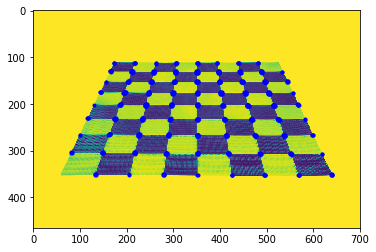

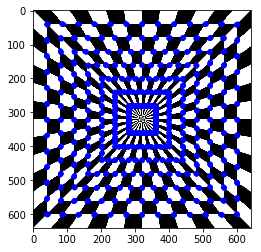

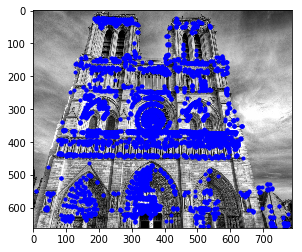

for  minimum eigen value thresold of  we were able to get approximately good harris corners 


In [7]:
image_name = ['input1.png','input2.png','input3.png']

counter = 1
i = 0

while i<3:
    hessian_corner(image_name[i],i+1)
    i+=1
print ("for  minimum eigen value thresold of  we were able to get approximately good harris corners ")


143
11829
2111


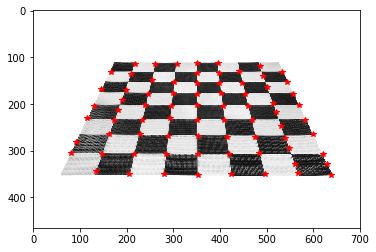

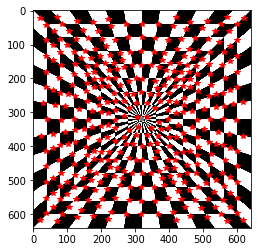

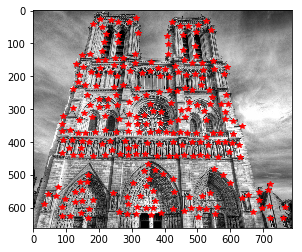

alpha = 0.04 and minimum distance of 10 we were able to get approximately good harris corners as alpha increases the threshold valuecornerness decreases and we will get more number of corner which are not real corners


In [8]:
counter = 1
i = 0
alpha = 0.04

while i<3:
    harriscorner(image_name[i],i+1)
    i+=1
plt.show()
print ("alpha = 0.04 and minimum distance of 10 we were able to get approximately good harris corners as alpha increases the threshold value" \
             "cornerness decreases and we will get more number of corner which are not real corners")

[111, 172]
 execution time for image  1 is  12.390118598937988
[1, 1]
 execution time for image  2 is  17.115535259246826
[7, 210]
 execution time for image  3 is  20.250207662582397


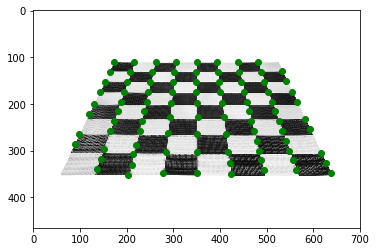

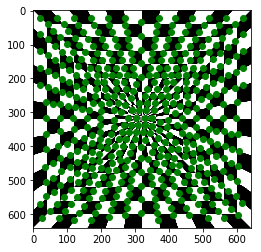

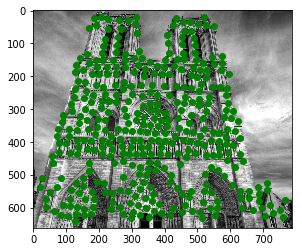

for  each image we get approximately same corners as of previous question but the amount of computation time is much larger compared to previous method 


In [9]:
counter = 1
i = 0
while i<3:
    st_time = time.time()
    cornerness(image_name[i],i+1)
    i+=1
    print(" execution time for image ",i,"is ",time.time()-st_time)
plt.show()
print("for  each image we get approximately same corners as of previous question but the amount of computation time is much larger compared to previous method ")